In [1]:
# import packages
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [2]:
# read data file
df = pd.read_csv('v7_Latest_Data_Science_Salaries.csv')


# Data Cleaning

### Cluster similar job titles together

In [3]:
tfidf_vectorizer = TfidfVectorizer()
job_title_tfidf = tfidf_vectorizer.fit_transform(df['Job_Title'])

num_clusters = 7  # not sure what value to use

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(job_title_tfidf)

cluster_labels = kmeans.labels_

df['Cluster'] = cluster_labels

cluster_names = {}

# Analyze job titles within each cluster and determine representative name
for cluster_id in range(num_clusters):
    job_titles = df[df['Cluster'] == cluster_id]['Job_Title'].tolist()
    job_titles_counter = Counter(job_titles)
    predominant_job_title = job_titles_counter.most_common(1)[0][0]
    cluster_names[cluster_id] = predominant_job_title

df['Cluster_name'] = df['Cluster'].map(cluster_names)

for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id} ({cluster_names[cluster_id]}):")
    job_titles = df[df['Cluster'] == cluster_id]['Job_Title'].tolist()
    for job_title in job_titles:
        print(job_title)
    print()

Cluster 0 (Data Engineer):
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Analytics Engineer
Analytics Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Analytics Engineer
Analytics Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Analytics Engineer
Analytics Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Analytics Engineer
Analytics Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engi

### Manually clean the messy cluster 1

In [4]:
# Keywords for each category
# If the jobs in cluster 1 contains these keywords then it'll be classified into that cluster instead
category_keywords = {
    'Data Architect': ['architect', 'architecture'],
    'Business Intelligence Analyst': ['BI', 'business intelligence'],
    'Data Engineer': ['data developer', 'ETL', 'engineer'],
    'Data Analyst': ['data analyst', 'analyst', 'analytics'],
    'Data Scientist': ['scientist', 'science'],
    'Machine Learning Engineer': ['AI', 'machine learning', 'ML', 'deep learning', 'NLP', 'computer vision'],
    'Research Scientist': ['research']
}

# Reclassify job titles in cluster 1 based on keywords
cluster_id = 1  # Cluster 1
job_titles_in_cluster_1 = df[df['Cluster'] == cluster_id]['Job_Title'].tolist()

# Initialize a dictionary to hold the reclassified job titles, their new cluster numbers, and cluster names
reclassified_jobs = {}

for job_title in job_titles_in_cluster_1:
    classified = False
    for category, keywords in category_keywords.items():
        if any(keyword.lower() in job_title.lower() for keyword in keywords):
            # Update the cluster number and store the reclassified job title and cluster name
            new_cluster = list(cluster_names.keys())[list(cluster_names.values()).index(category)]
            reclassified_jobs[job_title] = {'cluster': new_cluster, 'cluster_name': category}
            classified = True
            break
    if not classified:
        # If the job title doesn't match any keywords, keep it in the same cluster
        reclassified_jobs[job_title] = {'cluster': cluster_id, 'cluster_name': cluster_names[cluster_id]}

# Update the 'Cluster' column in the dataframe with the new cluster numbers and cluster names for reclassified jobs
for job_title, data in reclassified_jobs.items():
    df.loc[df['Job_Title'] == job_title, 'Cluster'] = data['cluster']
    df.loc[df['Job_Title'] == job_title, 'Cluster_name'] = data['cluster_name']

# Print the updated clusters
for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id} ({cluster_names[cluster_id]}):")
    job_titles = df[df['Cluster'] == cluster_id]['Job_Title'].tolist()
    for job_title in job_titles:
        print(job_title)
    print()


Cluster 0 (Data Engineer):
Data Engineer
Data Engineer
Data Developer
Data Developer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
AI Engineer
AI Engineer
Data Science Engineer
Data Science Engineer
Data Engineer
Data Engineer
Data Engineer
Analytics Engineer
Analytics Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Analytics Engineer
Analytics Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Analytics Engineer
Analytics Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
ETL Developer
ETL Developer
Data Engineer
Data Engineer
Data Engineer
Data Engineer
Prompt Engineer
Prompt Engineer
ML Engineer
ML Engineer
Analy

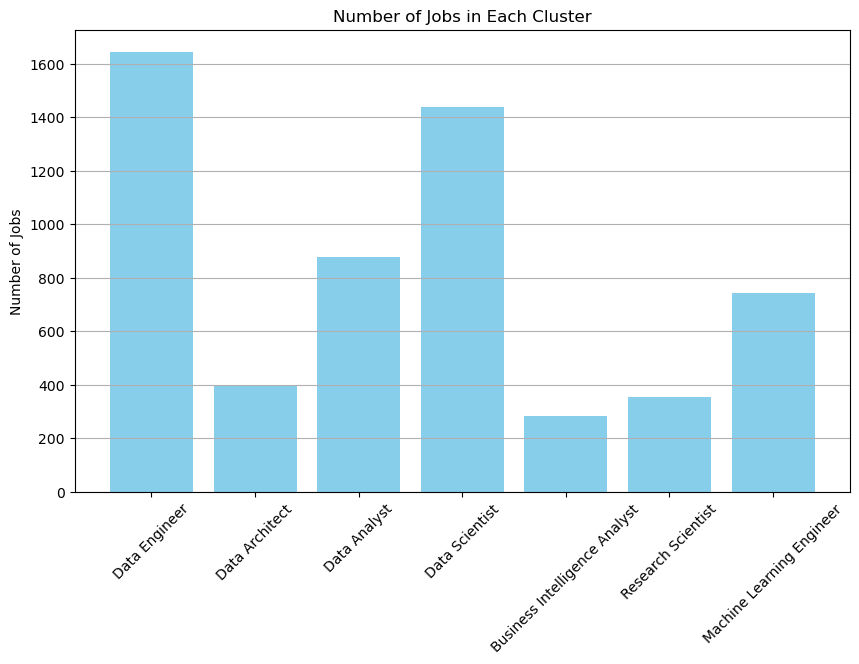

In [5]:
# Dictionary mapping cluster numbers to cluster names
cluster_names_dict = {
    0: 'Data Engineer',
    1: 'Data Architect',
    2: 'Data Analyst',
    3: 'Data Scientist',
    4: 'Business Intelligence Analyst',
    5: 'Research Scientist',
    6: 'Machine Learning Engineer'
}

# Count the number of job titles in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.ylabel('Number of Jobs')
plt.title('Number of Jobs in Each Cluster')
plt.xticks(list(cluster_names_dict.keys()), list(cluster_names_dict.values()), rotation=45)
plt.grid(axis='y')
plt.show()

C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


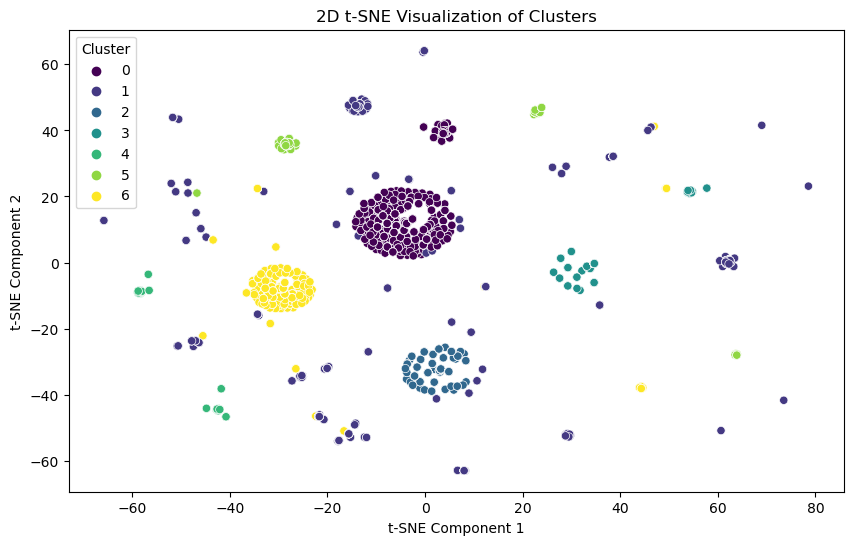

In [6]:
from sklearn.manifold import TSNE

# Fit t-SNE to the TF-IDF vectors
tsne = TSNE(n_components=2, random_state=42)
job_title_tsne = tsne.fit_transform(job_title_tfidf)

# Plot clusters in 2D t-SNE space
plt.figure(figsize=(10, 6))
sns.scatterplot(x=job_title_tsne[:, 0], y=job_title_tsne[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('2D t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


In [7]:
# Remove outliers
# Calculate the first quartile (Q1)
Q1 = df['Salary_in_USD'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = df['Salary_in_USD'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Salary_in_USD'] < lower_bound) | (df['Salary_in_USD'] > upper_bound)]

# Remove outliers
df = df[(df['Salary_in_USD'] >= lower_bound) & (df['Salary_in_USD'] <= upper_bound)]

# Display the outliers
print("Outliers:")
display(outliers)

# Display the cleaned DataFrame
print("\nDataFrame after removing outliers:")
display(df)

Outliers:


,Job_Title,Employment_Type,Experience_Level,Expertise_Level,Salary,Salary_Currency,Company_Location,Company_Continent,Salary_in_USD,Employee_Residence,Company_Size,Year,Cluster,Cluster_name
72,Data Scientist,Full-Time,Senior,Expert,324000,United States Dollar,United States,North America,324000,United States,Medium,2024,3,Data Scientist
110,Machine Learning Engineer,Full-Time,Senior,Expert,324000,United States Dollar,United States,North America,324000,United States,Medium,2024,6,Machine Learning Engineer
455,Data Engineer,Full-Time,Senior,Expert,333500,United States Dollar,United States,North America,333500,United States,Medium,2023,0,Data Engineer
507,Machine Learning Scientist,Full-Time,Mid,Intermediate,750000,United States Dollar,United States,North America,750000,United States,Medium,2023,6,Machine Learning Engineer
511,Machine Learning Engineer,Full-Time,Mid,Intermediate,750000,United States Dollar,United States,North America,750000,United States,Medium,2023,6,Machine Learning Engineer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5521,Research Scientist,Full-Time,Mid,Intermediate,450000,United States Dollar,United States,North America,450000,United States,Medium,2020,5,Research Scientist
5664,Principal Data Scientist,Contract,Executive,Director,416000,United States Dollar,United States,North America,416000,United States,Small,2021,3,Data Scientist
5683,Director of Data Science,Full-Time,Executive,Director,325000,United States Dollar,United States,North America,325000,United States,Large,2020,3,Data Scientist
5728,Applied Machine Learning Scientist,Full-Time,Mid,Intermediate,423000,United States Dollar,United States,North America,423000,United States,Large,2021,6,Machine Learning Engineer



DataFrame after removing outliers:


,Job_Title,Employment_Type,Experience_Level,Expertise_Level,Salary,Salary_Currency,Company_Location,Company_Continent,Salary_in_USD,Employee_Residence,Company_Size,Year,Cluster,Cluster_name
0,Data Engineer,Full-Time,Mid,Intermediate,138000,United States Dollar,United States,North America,138000,United States,Medium,2024,0,Data Engineer
1,Data Engineer,Full-Time,Mid,Intermediate,86000,United States Dollar,United States,North America,86000,United States,Medium,2024,0,Data Engineer
2,Data Analyst,Full-Time,Entry,Junior,179000,United States Dollar,United States,North America,179000,United States,Medium,2024,2,Data Analyst
3,Data Analyst,Full-Time,Entry,Junior,112000,United States Dollar,United States,North America,112000,United States,Medium,2024,2,Data Analyst
4,Business Intelligence Developer,Full-Time,Mid,Intermediate,92000,United States Dollar,United States,North America,92000,United States,Medium,2024,4,Business Intelligence Analyst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,Data Specialist,Full-Time,Senior,Expert,165000,United States Dollar,United States,North America,165000,United States,Large,2021,1,Data Architect
5732,Principal Data Scientist,Full-Time,Mid,Intermediate,151000,United States Dollar,United States,North America,151000,United States,Large,2021,3,Data Scientist
5733,Data Scientist,Full-Time,Entry,Junior,105000,United States Dollar,United States,North America,105000,United States,Small,2020,3,Data Scientist
5734,Business Data Analyst,Contract,Entry,Junior,100000,United States Dollar,United States,North America,100000,United States,Large,2020,4,Business Intelligence Analyst


In [8]:
#remove unecessary columns
df = df.drop(columns = ['Salary', 'Salary_Currency', 'Job_Title', 'Cluster', 'Company_Location', 'Year', 'Employee_Residence'])

#check for n.a values
print('Number of N.A values in each column')
print(df.isna().sum())



Number of N.A values in each column
Employment_Type      0
Experience_Level     0
Expertise_Level      0
Company_Continent    0
Salary_in_USD        0
Company_Size         0
Cluster_name         0
dtype: int64


## One hot encoding

In [9]:
columns_to_encode = ['Employment_Type', 'Experience_Level', 'Expertise_Level', 'Company_Continent', 'Company_Size', 'Cluster_name']
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True, dtype = int)

df.head()

,Salary_in_USD,Employment_Type_Freelance,Employment_Type_Full-Time,Employment_Type_Part-Time,Experience_Level_Executive,Experience_Level_Mid,Experience_Level_Senior,Expertise_Level_Expert,Expertise_Level_Intermediate,Expertise_Level_Junior,...,Company_Continent_Middle East & Africa,Company_Continent_North America,Company_Size_Medium,Company_Size_Small,Cluster_name_Data Analyst,Cluster_name_Data Architect,Cluster_name_Data Engineer,Cluster_name_Data Scientist,Cluster_name_Machine Learning Engineer,Cluster_name_Research Scientist
0,138000,0,1,0,0,1,0,0,1,0,...,0,1,1,0,0,0,1,0,0,0
1,86000,0,1,0,0,1,0,0,1,0,...,0,1,1,0,0,0,1,0,0,0
2,179000,0,1,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,0
3,112000,0,1,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,0
4,92000,0,1,0,0,1,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0


In [10]:
X = df.drop(columns=['Salary_in_USD'])  
y = df['Salary_in_USD']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Train and evaluate using 5-fold Cross Validation

### R-square = 0.319, RMSE = 51558 

In [11]:
# Initialize the linear regression model
model = LinearRegression()

# Define the k-fold cross-validator (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=21)

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False) 
r2_scorer = make_scorer(r2_score)

# Perform cross-validation
mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=mse_scorer)
mse_scores = -mse_scores
r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=r2_scorer)

# Calculate the average MSE and R^2 values across all folds
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)

print(f"MSE scores: {mse_scores}")
print(f"R^2 scores: {r2_scores}")

print(f"Average MSE score: {average_mse}")
print(f"Average R^2 score: {average_r2}")

# Fit the model on the entire training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred_test = model.predict(X_test)

# Evaluate performance on the test set
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = test_mse ** 0.5

print(f"Test MSE score: {test_mse}")
print(f"Test RMSE score: {test_rmse}")
print(f"Test R^2 score: {test_r2}")

MSE scores: [2.37067497e+09 2.40088167e+09 2.65617473e+09 2.72403709e+09
 2.66122816e+09]
R^2 scores: [0.39709648 0.37980078 0.38482715 0.31615459 0.34587648]
Average MSE score: 2562599325.4054837
Average R^2 score: 0.3647510951501838
Test MSE score: 2658256691.7073746
Test RMSE score: 51558.28441392687
Test R^2 score: 0.31867035477865646


### Bootstrapping

### R-square = 0.316, RMSE = 51678

In [12]:
# Initialize the linear regression model
model = LinearRegression()

# Define the number of bootstrap samples
n_bootstrap_samples = 500

mse_scores = []
r2_scores = []

# Perform bootstrap sampling
for _ in range(n_bootstrap_samples):
    # Generate bootstrapped indices
    indices = resample(np.arange(len(X_train)), replace=True)

    # Extract bootstrapped sample from the training set
    X_boot_train, y_boot_train = pd.DataFrame(X_train).iloc[indices], pd.DataFrame(y_train).iloc[indices]

    # Fit the model on the bootstrapped training set
    model.fit(X_boot_train, y_boot_train)

    # Predict on the original test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate the average MSE and R^2 values across all bootstrap samples
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)

print(f"Average MSE (over test set): {average_mse}")
print(f"Average RMSE (over test set): {np.sqrt(average_mse)}")
print(f"Average R^2 (over test set): {average_r2}")

Average MSE (over test set): 2670749020.834413
Average RMSE (over test set): 51679.29005737611
Average R^2 (over test set): 0.31546848409451034


# Model selection

### Elastic Net (MSE)

## R-square = 0.319 RMSE = 51545

In [13]:
# Initialize ElasticNet model
elastic_net = ElasticNet(random_state=42)

# Define hyperparameters to tune
params = {
    'alpha': [0.1, 0.5, 1, 2, 5, 10], #this is lambda is slides formula 6ModelSelection
    # Currently, l1_ratio <= 0.01 is not reliable
    'l1_ratio': np.arange(0.05, 1.05, 0.05), #this is the alpha in the slides notes
    'max_iter': [10000] #e.g. in the case of gradient descent this no. is how many times the ship moves left and right
}

# Set up GridSearchCV 
grid_search = GridSearchCV(estimator=elastic_net, param_grid=params, cv=5, scoring='neg_mean_squared_error', 
                            verbose=3, #can be 2 or 3 or 4 (look up website each verbose returns diff things)
                           #for 3 for each training it tells you training and test error
                          return_train_score=True)

# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END alpha=0.1, l1_ratio=0.05, max_iter=10000;, score=(train=-2545349352.413, test=-2620871721.447) total time=   0.0s
[CV 2/5] END alpha=0.1, l1_ratio=0.05, max_iter=10000;, score=(train=-2582748278.783, test=-2476960528.235) total time=   0.0s
[CV 3/5] END alpha=0.1, l1_ratio=0.05, max_iter=10000;, score=(train=-2583075268.042, test=-2476280884.770) total time=   0.0s
[CV 4/5] END alpha=0.1, l1_ratio=0.05, max_iter=10000;, score=(train=-2549099486.155, test=-2609125867.393) total time=   0.0s
[CV 5/5] END alpha=0.1, l1_ratio=0.05, max_iter=10000;, score=(train=-2526827368.244, test=-2716819253.997) total time=   0.0s
[CV 1/5] END alpha=0.1, l1_ratio=0.1, max_iter=10000;, score=(train=-2544258034.686, test=-2620184620.435) total time=   0.0s
[CV 2/5] END alpha=0.1, l1_ratio=0.1, max_iter=10000;, score=(train=-2581725986.335, test=-2475932898.876) total time=   0.0s
[CV 3/5] END alpha=0.1, l1_ratio=0.1, max_iter=100

[CV 3/5] END alpha=0.1, l1_ratio=0.7500000000000001, max_iter=10000;, score=(train=-2565411314.125, test=-2464981717.670) total time=   0.0s
[CV 4/5] END alpha=0.1, l1_ratio=0.7500000000000001, max_iter=10000;, score=(train=-2531951261.535, test=-2599566120.289) total time=   0.0s
[CV 5/5] END alpha=0.1, l1_ratio=0.7500000000000001, max_iter=10000;, score=(train=-2511731928.211, test=-2692522064.695) total time=   0.0s
[CV 1/5] END alpha=0.1, l1_ratio=0.8, max_iter=10000;, score=(train=-2527715059.561, test=-2609744414.109) total time=   0.0s
[CV 2/5] END alpha=0.1, l1_ratio=0.8, max_iter=10000;, score=(train=-2565949804.795, test=-2458130217.271) total time=   0.0s
[CV 3/5] END alpha=0.1, l1_ratio=0.8, max_iter=10000;, score=(train=-2564159509.510, test=-2464696742.594) total time=   0.0s
[CV 4/5] END alpha=0.1, l1_ratio=0.8, max_iter=10000;, score=(train=-2530753457.387, test=-2599175685.086) total time=   0.0s
[CV 5/5] END alpha=0.1, l1_ratio=0.8, max_iter=10000;, score=(train=-2510

[CV 3/5] END alpha=0.5, l1_ratio=0.7000000000000001, max_iter=10000;, score=(train=-2594628848.006, test=-2486386346.355) total time=   0.0s
[CV 4/5] END alpha=0.5, l1_ratio=0.7000000000000001, max_iter=10000;, score=(train=-2560549075.566, test=-2616804152.785) total time=   0.0s
[CV 5/5] END alpha=0.5, l1_ratio=0.7000000000000001, max_iter=10000;, score=(train=-2537177803.956, test=-2731392628.897) total time=   0.0s
[CV 1/5] END alpha=0.5, l1_ratio=0.7500000000000001, max_iter=10000;, score=(train=-2551647233.959, test=-2624872491.107) total time=   0.0s
[CV 2/5] END alpha=0.5, l1_ratio=0.7500000000000001, max_iter=10000;, score=(train=-2588649660.670, test=-2482689674.314) total time=   0.0s
[CV 3/5] END alpha=0.5, l1_ratio=0.7500000000000001, max_iter=10000;, score=(train=-2589561302.645, test=-2481808145.747) total time=   0.0s
[CV 4/5] END alpha=0.5, l1_ratio=0.7500000000000001, max_iter=10000;, score=(train=-2555506876.812, test=-2613343192.336) total time=   0.0s
[CV 5/5] END 

[CV 3/5] END alpha=1, l1_ratio=0.5, max_iter=10000;, score=(train=-2661319001.449, test=-2552063979.411) total time=   0.0s
[CV 4/5] END alpha=1, l1_ratio=0.5, max_iter=10000;, score=(train=-2628394186.006, test=-2670341106.931) total time=   0.0s
[CV 5/5] END alpha=1, l1_ratio=0.5, max_iter=10000;, score=(train=-2601841175.640, test=-2812150824.254) total time=   0.0s
[CV 1/5] END alpha=1, l1_ratio=0.55, max_iter=10000;, score=(train=-2615099586.278, test=-2672311443.637) total time=   0.0s
[CV 2/5] END alpha=1, l1_ratio=0.55, max_iter=10000;, score=(train=-2649824524.451, test=-2537266515.395) total time=   0.0s
[CV 3/5] END alpha=1, l1_ratio=0.55, max_iter=10000;, score=(train=-2651598400.740, test=-2542428908.416) total time=   0.0s
[CV 4/5] END alpha=1, l1_ratio=0.55, max_iter=10000;, score=(train=-2618445637.720, test=-2661997999.358) total time=   0.0s
[CV 5/5] END alpha=1, l1_ratio=0.55, max_iter=10000;, score=(train=-2592201926.913, test=-2800640216.985) total time=   0.0s
[CV

C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.899e+09, tolerance: 1.282e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=1, l1_ratio=1.0, max_iter=10000;, score=(train=-2563129460.714, test=-2453799050.050) total time=   0.5s


C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.826e+09, tolerance: 1.289e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=1, l1_ratio=1.0, max_iter=10000;, score=(train=-2561026783.935, test=-2467134690.743) total time=   0.4s
[CV 4/5] END alpha=1, l1_ratio=1.0, max_iter=10000;, score=(train=-2527772398.362, test=-2600152598.179) total time=   0.0s
[CV 5/5] END alpha=1, l1_ratio=1.0, max_iter=10000;, score=(train=-2508061394.224, test=-2682247798.838) total time=   0.0s
[CV 1/5] END alpha=2, l1_ratio=0.05, max_iter=10000;, score=(train=-2888575915.361, test=-2927226485.339) total time=   0.0s
[CV 2/5] END alpha=2, l1_ratio=0.05, max_iter=10000;, score=(train=-2921451161.412, test=-2798466574.385) total time=   0.0s
[CV 3/5] END alpha=2, l1_ratio=0.05, max_iter=10000;, score=(train=-2918112297.717, test=-2797575745.184) total time=   0.0s
[CV 4/5] END alpha=2, l1_ratio=0.05, max_iter=10000;, score=(train=-2889729043.522, test=-2901723977.745) total time=   0.0s
[CV 5/5] END alpha=2, l1_ratio=0.05, max_iter=10000;, score=(train=-2856255097.759, test=-3103012303.463) total time=   0.0s
[CV

[CV 4/5] END alpha=2, l1_ratio=0.8, max_iter=10000;, score=(train=-2608625209.601, test=-2653866875.904) total time=   0.0s
[CV 5/5] END alpha=2, l1_ratio=0.8, max_iter=10000;, score=(train=-2582716162.635, test=-2789207684.549) total time=   0.0s
[CV 1/5] END alpha=2, l1_ratio=0.8500000000000001, max_iter=10000;, score=(train=-2585527621.861, test=-2648633797.849) total time=   0.0s
[CV 2/5] END alpha=2, l1_ratio=0.8500000000000001, max_iter=10000;, score=(train=-2620971596.466, test=-2511551978.207) total time=   0.0s
[CV 3/5] END alpha=2, l1_ratio=0.8500000000000001, max_iter=10000;, score=(train=-2623050680.146, test=-2514003990.212) total time=   0.0s
[CV 4/5] END alpha=2, l1_ratio=0.8500000000000001, max_iter=10000;, score=(train=-2589274206.812, test=-2638266565.779) total time=   0.0s
[CV 5/5] END alpha=2, l1_ratio=0.8500000000000001, max_iter=10000;, score=(train=-2564134891.254, test=-2766377204.014) total time=   0.0s
[CV 1/5] END alpha=2, l1_ratio=0.9000000000000001, max_it

C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.596e+09, tolerance: 1.273e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=2, l1_ratio=1.0, max_iter=10000;, score=(train=-2524917127.361, test=-2608257031.036) total time=   0.4s


C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.911e+09, tolerance: 1.282e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=2, l1_ratio=1.0, max_iter=10000;, score=(train=-2563129653.299, test=-2453802101.298) total time=   0.4s


C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.839e+09, tolerance: 1.289e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=2, l1_ratio=1.0, max_iter=10000;, score=(train=-2561026966.884, test=-2467118154.452) total time=   0.4s


C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.713e+09, tolerance: 1.283e+09
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=2, l1_ratio=1.0, max_iter=10000;, score=(train=-2527772577.682, test=-2600118760.581) total time=   0.5s


C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.678e+09, tolerance: 1.254e+09
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=2, l1_ratio=1.0, max_iter=10000;, score=(train=-2508061561.059, test=-2682248459.787) total time=   0.4s
[CV 1/5] END alpha=5, l1_ratio=0.05, max_iter=10000;, score=(train=-3218990860.103, test=-3255499950.097) total time=   0.0s
[CV 2/5] END alpha=5, l1_ratio=0.05, max_iter=10000;, score=(train=-3251113425.469, test=-3131033954.554) total time=   0.0s
[CV 3/5] END alpha=5, l1_ratio=0.05, max_iter=10000;, score=(train=-3248667635.219, test=-3104233082.108) total time=   0.0s
[CV 4/5] END alpha=5, l1_ratio=0.05, max_iter=10000;, score=(train=-3222907898.412, test=-3203396038.999) total time=   0.0s
[CV 5/5] END alpha=5, l1_ratio=0.05, max_iter=10000;, score=(train=-3177669654.300, test=-3461029929.746) total time=   0.0s
[CV 1/5] END alpha=5, l1_ratio=0.1, max_iter=10000;, score=(train=-3197754325.064, test=-3234171792.779) total time=   0.0s
[CV 2/5] END alpha=5, l1_ratio=0.1, max_iter=10000;, score=(train=-3229926728.199, test=-3109448242.101) total time=   0.0s
[CV

C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.628e+09, tolerance: 1.273e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=5, l1_ratio=1.0, max_iter=10000;, score=(train=-2524918423.737, test=-2608265821.987) total time=   0.4s


C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.944e+09, tolerance: 1.282e+09
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END alpha=5, l1_ratio=1.0, max_iter=10000;, score=(train=-2563131001.396, test=-2453812156.013) total time=   0.4s


C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.873e+09, tolerance: 1.289e+09
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END alpha=5, l1_ratio=1.0, max_iter=10000;, score=(train=-2561028247.528, test=-2467069203.393) total time=   0.4s


C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.748e+09, tolerance: 1.283e+09
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END alpha=5, l1_ratio=1.0, max_iter=10000;, score=(train=-2527773859.958, test=-2600054648.189) total time=   0.4s


C:\Users\yuxuan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.711e+09, tolerance: 1.254e+09
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END alpha=5, l1_ratio=1.0, max_iter=10000;, score=(train=-2508062736.162, test=-2682233370.147) total time=   0.5s
[CV 1/5] END alpha=10, l1_ratio=0.05, max_iter=10000;, score=(train=-3484113333.058, test=-3523082541.455) total time=   0.0s
[CV 2/5] END alpha=10, l1_ratio=0.05, max_iter=10000;, score=(train=-3515479440.972, test=-3401671127.963) total time=   0.0s
[CV 3/5] END alpha=10, l1_ratio=0.05, max_iter=10000;, score=(train=-3518350924.266, test=-3352871460.149) total time=   0.0s
[CV 4/5] END alpha=10, l1_ratio=0.05, max_iter=10000;, score=(train=-3493739226.957, test=-3449909697.802) total time=   0.0s
[CV 5/5] END alpha=10, l1_ratio=0.05, max_iter=10000;, score=(train=-3435999810.658, test=-3745612596.976) total time=   0.0s
[CV 1/5] END alpha=10, l1_ratio=0.1, max_iter=10000;, score=(train=-3464675439.242, test=-3503402358.711) total time=   0.0s
[CV 2/5] END alpha=10, l1_ratio=0.1, max_iter=10000;, score=(train=-3496106938.022, test=-3381776065.637) total time=   0

[CV 1/5] END alpha=10, l1_ratio=1.0, max_iter=10000;, score=(train=-2524923043.302, test=-2608284124.910) total time=   0.2s
[CV 2/5] END alpha=10, l1_ratio=1.0, max_iter=10000;, score=(train=-2563135806.828, test=-2453830824.661) total time=   0.3s
[CV 3/5] END alpha=10, l1_ratio=1.0, max_iter=10000;, score=(train=-2561032811.209, test=-2466990448.432) total time=   0.3s
[CV 4/5] END alpha=10, l1_ratio=1.0, max_iter=10000;, score=(train=-2527778429.023, test=-2599950983.928) total time=   0.3s
[CV 5/5] END alpha=10, l1_ratio=1.0, max_iter=10000;, score=(train=-2508066925.509, test=-2682210129.325) total time=   0.3s


GridSearchCV(cv=5, estimator=ElasticNet(random_state=42),
             param_grid={'alpha': [0.1, 0.5, 1, 2, 5, 10],
                         'l1_ratio': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'max_iter': [10000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [14]:
# Assuming you have a DataFrame df that was used to create X
feature_names = df.drop('Salary_in_USD', axis=1).columns

best_model = grid_search.best_estimator_

# Get coefficients from the best model
coefficients = best_model.coef_

# Create a DataFrame to associate coefficients with feature names
feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Filter out features with coefficient equal to zero (or very close to zero)
selected_features = feature_coefficients[feature_coefficients['Coefficient'] != 0]

# Print the selected features
print("Selected Features:")
print(selected_features)


Selected Features:
                                   Feature   Coefficient
0                Employment_Type_Freelance -6.541278e+02
1                Employment_Type_Full-Time  1.453673e+03
2                Employment_Type_Part-Time  8.988192e+02
3               Experience_Level_Executive  1.086930e+04
5                  Experience_Level_Senior  1.479340e+04
6                   Expertise_Level_Expert  8.691686e-09
8                   Expertise_Level_Junior -6.409545e+03
9                 Company_Continent_Europe  6.808321e+02
10        Company_Continent_LATAM & Others -1.353031e+03
11  Company_Continent_Middle East & Africa -6.036875e+02
12         Company_Continent_North America  2.125036e+04
13                     Company_Size_Medium  2.750455e+03
14                      Company_Size_Small -2.570588e+03
15               Cluster_name_Data Analyst -1.717462e+03
16             Cluster_name_Data Architect  3.473345e+03
17              Cluster_name_Data Engineer  1.125293e+04
18          

In [15]:
# Extract the selected features from the training and test sets
X_train_selected = X_train_scaled[:, best_model.coef_ != 0]
X_test_selected = X_test_scaled[:, best_model.coef_ != 0]

# Initialize ElasticNet model with the best hyperparameters
elastic_net_best = ElasticNet(alpha=best_model.alpha, l1_ratio=best_model.l1_ratio, max_iter=best_model.max_iter, random_state=42)

# Fit the model on the training data with selected features
elastic_net_best.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_test = elastic_net_best.predict(X_test_selected)

# Evaluate the model on the test set
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred_test)

print("Test Mean Squared Error:", test_mse)
print("Test Root Mean Squared Error:", test_rmse)
print("Test R-squared:", test_r2)


Test Mean Squared Error: 2656900004.140899
Test Root Mean Squared Error: 51545.125900912295
Test R-squared: 0.31901808322084435


# Model 2: Decision Tree

## R-square = 0.324 RMSE = 51375 (after pruning)

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt




Mean Squared Error: 2736457339.774473
Root Mean Squared Error: 52311.15884564663
R-squared: 0.2986269857654804


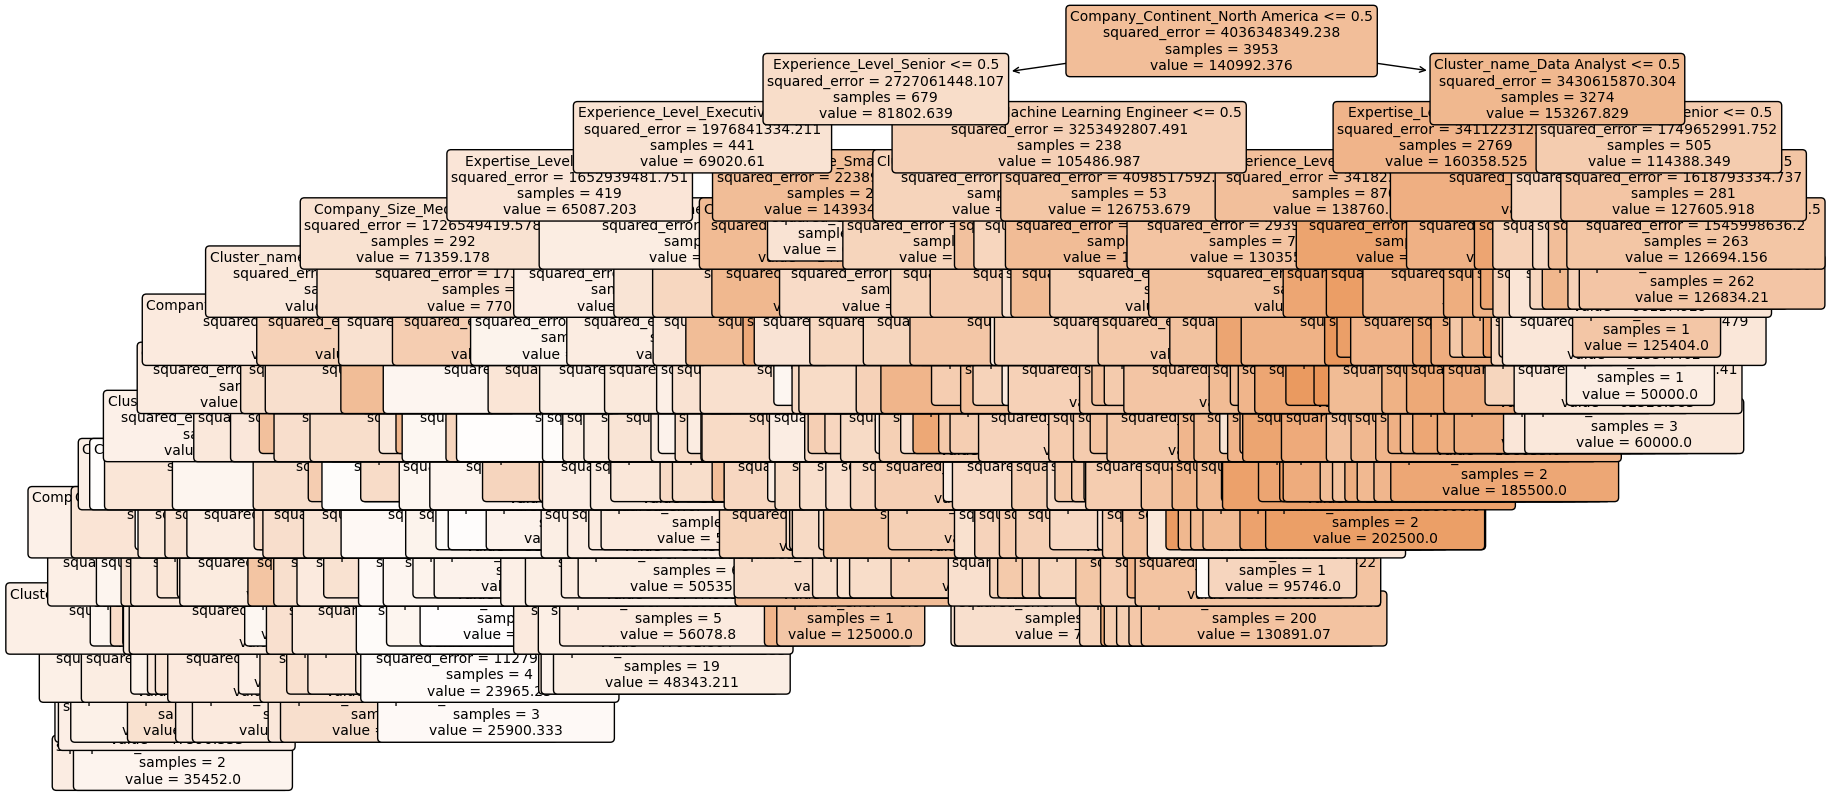

In [17]:
# Create a Decision Tree Classifier
clf = DecisionTreeRegressor(random_state=42)

# Fit the classifier on the entire training data
clf.fit(X_train, y_train)

# Evaluate the classification tree on the test data
y_pred = clf.predict(X_test)

# Calculate evaluation metric (e.g., Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r_squared = clf.score(X_test, y_test)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r_squared)

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities



plt.figure(figsize=(20,10))  # Set the figure size
plot_tree(clf, feature_names=X_train.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.show()


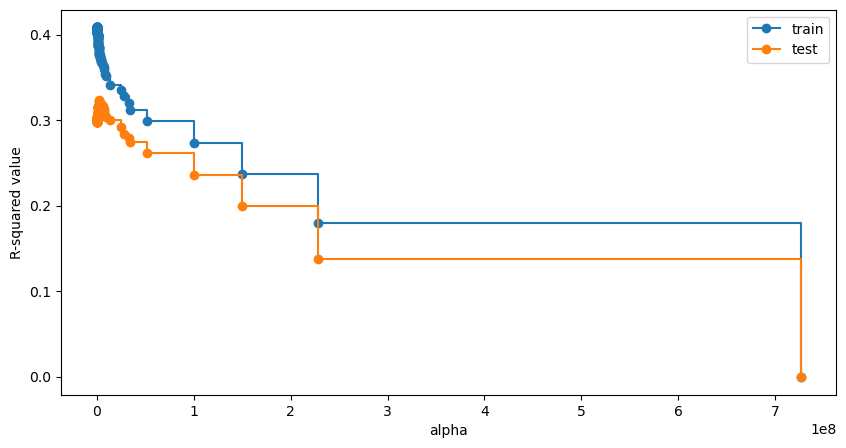

In [18]:
# Create a Decision Tree Regressor
clf = DecisionTreeRegressor(random_state=42)

# Fit the classifier on the entire training data
clf.fit(X_train, y_train)

# Cost-complexity pruning
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Create an array of decision trees
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Calculate the validation scores
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# Plotting validation curves
plt.figure(figsize=(10, 5))
plt.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("R-squared value")
plt.legend()
plt.show()

R-squared: 0.32350095008081803
Mean Squared Error (MSE): 2639409776.1548753
Root Mean Squared Error (RMSE): 51375.18638559743
Best alpha: 2446056.8836013563


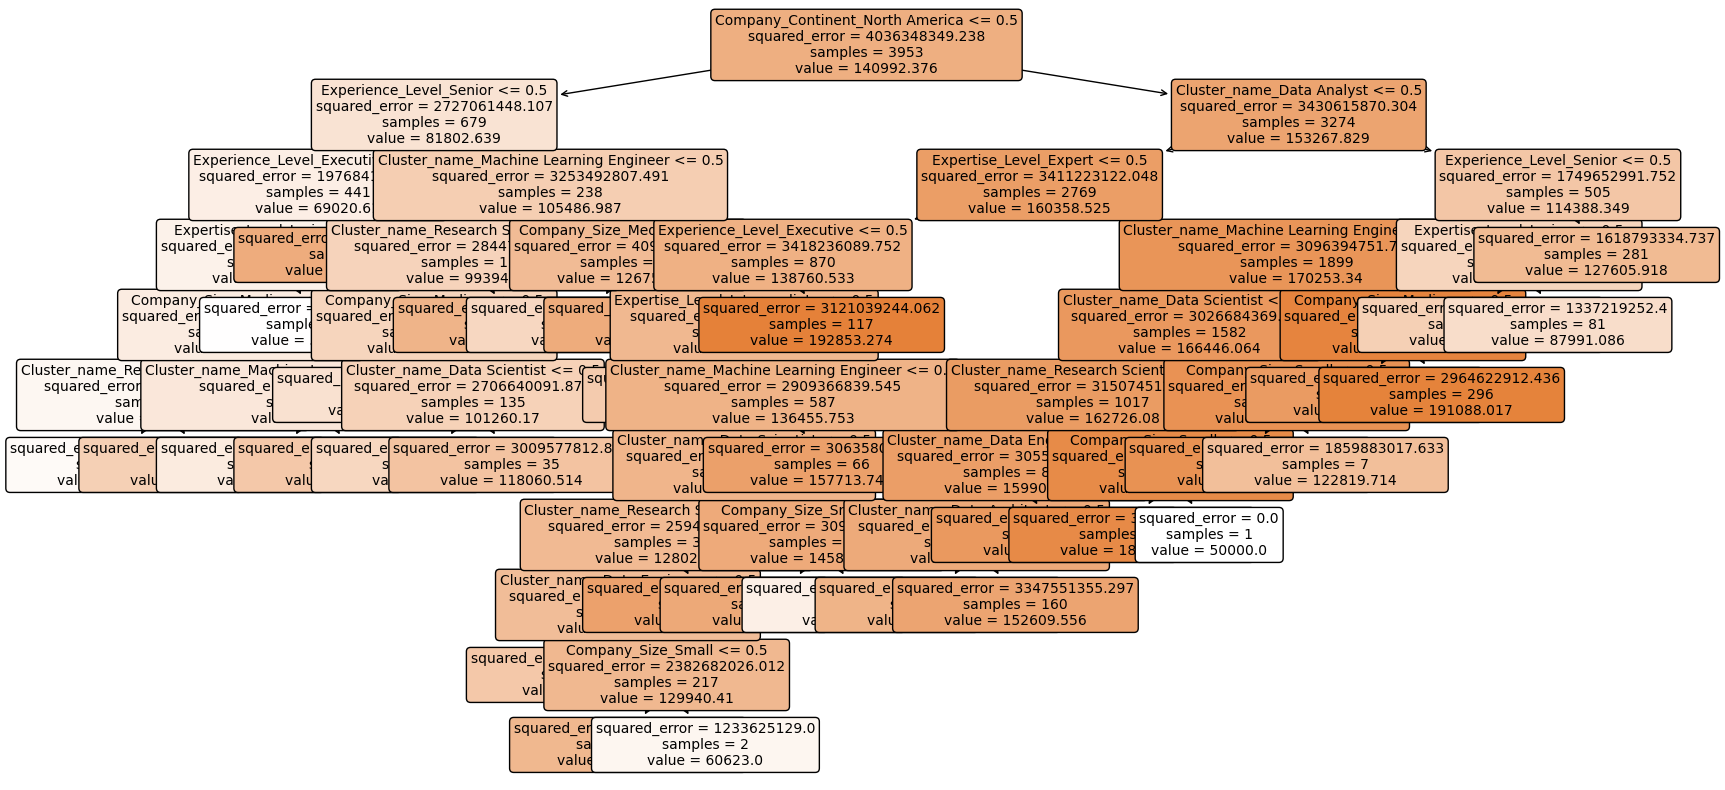

In [19]:
# Find the best alpha value that maximizes R-squared on the test set
best_alpha = ccp_alphas[np.argmax(test_scores)]

# Create a decision tree regressor with the best alpha value
pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)

# Fit the pruned tree on the entire training data
pruned_tree.fit(X_train, y_train)

# Predict on the test set
y_pred = pruned_tree.predict(X_test)

# Calculate R-squared value
r_squared = pruned_tree.score(X_test, y_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print R-squared and RMSE
print("R-squared:", r_squared)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Best alpha:", best_alpha)

# Visualize the pruned decision tree
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X_train.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.show()


## XGBoost

### R square = 0.354, RMSE = 50218

In [20]:
import xgboost as xgb

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X, label=y)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',  # Root Mean Squared Error
    'eta': 0.1,  # Learning rate
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'seed': 42
}

# Perform cross-validation
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Number of boosting rounds
    nfold=5,  # Number of folds for cross-validation
    metrics='rmse',  # Evaluation metric
    early_stopping_rounds=10,  # Early stopping to prevent overfitting
    verbose_eval=10,  # Show progress every 10 rounds
    seed=42
)

# Get the best number of boosting rounds
best_num_boost_rounds = cv_results['test-rmse-mean'].idxmin()

# Train the final model with the best number of boosting rounds
final_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_rounds,
    verbose_eval=10
)

# Predict on the test set
dtest = xgb.DMatrix(X_test)
y_pred = final_model.predict(dtest)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared value
r_squared = r2_score(y_test, y_pred)

print("R-squared:", r_squared)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


[0]	train-rmse:61059.01254+365.64551	test-rmse:61116.69663+1529.76596
[10]	train-rmse:51999.06230+385.90136	test-rmse:52607.40714+1573.89003
[20]	train-rmse:50355.65180+393.68455	test-rmse:51284.96669+1580.20042
[30]	train-rmse:49920.05619+386.02186	test-rmse:51084.31806+1592.68711
[40]	train-rmse:49694.91990+396.05186	test-rmse:51038.06678+1545.29140
[50]	train-rmse:49601.50130+389.51002	test-rmse:51065.77894+1539.45043
[51]	train-rmse:49595.02046+389.66414	test-rmse:51068.47108+1534.75583
R-squared: 0.35362113626753056
Mean Squared Error (MSE): 2521893699.9825416
Root Mean Squared Error (RMSE): 50218.45975318779
